In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from identification import vif_detection
import time
import matplotlib.pyplot as plt
import csv

In [2]:
### Load in Data ###
data = pd.read_csv("data_cleaning/final_data.csv")


vars = ["REGION_YEAR","AGELAST","SEX","RACETHX","MARRY_YEARX","EDUCYR",
"BORNUSA","FOODST_YEAR","TTLP_YEARX","FAMINC_YEAR","POVCAT_YEAR","POVLEV_YEAR","WAGEP_YEARX",
"DIVDP_YEARX","SALEP_YEARX","PENSP_YEARX","PUBP_YEARX","ADHDADDX","ACTDTY",
'UNINSURED_ONLY', 'PRIVATE_ONLY', 'MEDICAID_ONLY', 'MEDICARE_ANY', 'MEDICARE_ADV', 'MEDICARE_MEDICAID', 'MEDICARE_PRIVATE',	
"RTHLTH","MNHLTH","EMPST","non_opioid_prescriptions","NUM_CONDITIONS","INJURY"]

data = data.dropna()

### Run identification ###
y = pd.DataFrame(data, columns=['opioid_prescribed_at_all'])
exog = pd.DataFrame(data, columns=vars)
exog_vars = vif_detection(data,exog, y)

### Data Normalization and Splitting ###
X=pd.DataFrame(exog_vars).to_numpy()
y=pd.DataFrame(y).to_numpy().reshape(len(y),)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_scaled = scaler.transform(X)
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X_scaled, y, random_state=42, test_size = 0.2)
X_valid, X_test, y_valid, y_test = train_test_split(X_test_valid, y_test_valid, random_state=42, test_size = 0.5)

In [3]:
baseline_majority_accuracy_valid = sum(y_valid) / len(y_valid)
print(f'baseline accuracy for valid {baseline_majority_accuracy_valid}')
baseline_majority_accuracy_test = sum(y_test) / len(y_test)
print(f'baseline accuracy for test {baseline_majority_accuracy_test}')

baseline accuracy for valid 0.1841505996660088
baseline accuracy for test 0.17789921068609593


In [4]:
### Model 1-Logistic Regression ###
start_time = time.time()
log_reg= LogisticRegression(max_iter = 1000).fit(X_train, y_train)  # apply scaling on training data
y_predict = log_reg.predict(X_valid)
log_reg_time = time.time() - start_time
log_reg_accuracy = accuracy_score(y_valid, y_predict)
log_reg_precision = precision_score(y_valid, y_predict)
log_reg_recall = recall_score(y_valid, y_predict)
log_reg_f1 = f1_score(y_valid, y_predict)
print(f"logistic model accuracy on valid: {log_reg_accuracy*100:.1f}%")
print(f"logistic model precision on valid: {log_reg_precision*100:.1f}%")
print(f"logistic model recall on valid: {log_reg_recall*100:.1f}%")
print(f"logistic model f1 on valid: {log_reg_f1*100:.1f}%")
print(f'logistic model time in seconds to predict valid: {log_reg_time:.1f} seconds')


#Save for ROC plot
y_pred = log_reg.predict_proba(X_test)[:, 1]
fpr_log, tpr_log, _ = metrics.roc_curve(y_test, y_pred)
auc_log = round(metrics.roc_auc_score(y_test, y_pred), 4)

logistic model accuracy on valid: 82.2%
logistic model precision on valid: 59.1%
logistic model recall on valid: 10.1%
logistic model f1 on valid: 17.3%
logistic model time in seconds to predict valid: 2.4 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [5]:
### Model 2-Decision Tree ###
start_time = time.time()
decision_tree = tree.DecisionTreeClassifier()
decision_tree = decision_tree.fit(X_train, y_train)
y_predict = decision_tree.predict(X_valid)
decision_tree_time = time.time() - start_time
decision_tree_accuracy = accuracy_score(y_valid, y_predict)
decision_tree_precision = precision_score(y_valid, y_predict)
decision_tree_recall = recall_score(y_valid, y_predict)
decision_tree_f1 = f1_score(y_valid, y_predict)

print(f"decision tree model accuracy on valid: {decision_tree_accuracy*100:.1f}%")
print(f"decision tree model precision on valid: {decision_tree_precision*100:.1f}%")
print(f"decision tree model recall on valid: {decision_tree_recall*100:.1f}%")
print(f"decision tree model f1 on valid: {decision_tree_f1*100:.1f}%")
print(f'decision tree model time in seconds to predict valid: {decision_tree_time:.1f} seconds')

#Save for ROC plot
y_pred = decision_tree.predict_proba(X_test)[:, 1]
fpr_tree, tpr_tree, _ = metrics.roc_curve(y_test, y_pred)
auc_tree = round(metrics.roc_auc_score(y_test, y_pred), 4)

decision tree model accuracy on valid: 73.3%
decision tree model precision on valid: 29.8%
decision tree model recall on valid: 33.3%
decision tree model f1 on valid: 31.5%
decision tree model time in seconds to predict valid: 0.4 seconds



random forest with 10 estimators
	accuracy on valid: 83.0%
	precision on valid: 65.1%
	recall on valid: 16.9%
	f1 on valid: 26.8%
	seconds to predict valid: 0.5 seconds

random forest with 50 estimators
	accuracy on valid: 83.4%
	precision on valid: 71.6%
	recall on valid: 16.0%
	f1 on valid: 26.1%
	seconds to predict valid: 2.5 seconds

random forest with 100 estimators
	accuracy on valid: 83.3%
	precision on valid: 70.6%
	recall on valid: 15.8%
	f1 on valid: 25.9%
	seconds to predict valid: 4.9 seconds

random forest with 250 estimators
	accuracy on valid: 83.3%
	precision on valid: 72.9%
	recall on valid: 15.1%
	f1 on valid: 25.0%
	seconds to predict valid: 12.1 seconds

random forest with 500 estimators
	accuracy on valid: 83.5%
	precision on valid: 75.7%
	recall on valid: 15.4%
	f1 on valid: 25.6%
	seconds to predict valid: 24.2 seconds


Text(0.5, 0, 'Importance')

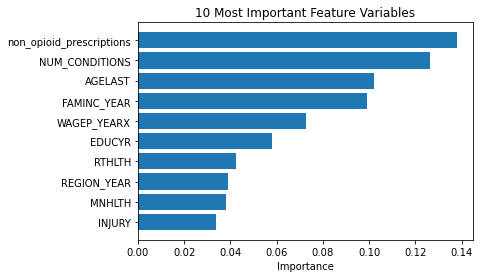

In [6]:
### Model 3-Random Forest ###
random_forest_times = []
random_forest_accuracy_scores = []
random_forest_precision_scores = []
random_forest_recall_scores = []
random_forest_f1_scores = []
max_recall = 0
for estimator in [10,50,100,250,500]:
    start_time = time.time()
    forest_model = RandomForestClassifier(random_state = 0, n_jobs = 1, n_estimators = estimator, class_weight = 'balanced')
    forest_model = forest_model.fit(X_train, y_train)
    y_predict = forest_model.predict(X_valid)

    forest_model_time = time.time() - start_time
    forest_model_accuracy = accuracy_score(y_valid, y_predict)
    forest_model_precision = precision_score(y_valid, y_predict)
    forest_model_recall = recall_score(y_valid, y_predict)
    forest_model_f1 = f1_score(y_valid, y_predict)
    if forest_model_recall > max_recall:
        importances = forest_model.feature_importances_
        #Save for ROC plot
        y_pred = forest_model.predict_proba(X_test)[:, 1]
        fpr_forest, tpr_forest, _ = metrics.roc_curve(y_test, y_pred)
        auc_forest = round(metrics.roc_auc_score(y_test, y_pred), 4)


    random_forest_times.append(forest_model_time)
    random_forest_accuracy_scores.append(forest_model_accuracy)
    random_forest_precision_scores.append(forest_model_precision)
    random_forest_recall_scores.append(forest_model_recall)
    random_forest_f1_scores.append(forest_model_f1)

    print(f'\nrandom forest with {estimator} estimators')
    print(f"\taccuracy on valid: {forest_model_accuracy*100:.1f}%")
    print(f"\tprecision on valid: {forest_model_precision*100:.1f}%")
    print(f"\trecall on valid: {forest_model_recall*100:.1f}%")
    print(f"\tf1 on valid: {forest_model_f1*100:.1f}%")
    print(f'\tseconds to predict valid: {forest_model_time:.1f} seconds')

indices = np.argsort(importances)
fig, ax = plt.subplots()
ax.barh(range(0,10), importances[indices[-10:]])
ax.set_yticks(range(0,10))
_ = ax.set_yticklabels(np.array(exog_vars.columns)[indices[-10:]])
plt.title('10 Most Important Feature Variables')
plt.xlabel('Importance')

In [8]:
### Model 4-Neural Net ###
nn_times = []
nn_accuracy_scores = []
nn_precision_scores = []
nn_recall_scores = []
nn_f1_scores = []
for layers in [(100,50,25), (10, 5, 2), (25, 25, 25), (10, 9, 8), (10, 5), (100, 25)]:
    for active_func in ['relu', 'tanh', 'logistic']:
        for alpha_val in [0.0001, 0.001, .01]:
            for max_iterations in [100, 200, 500]:
                for type_of_solver in ['sgd', 'adam']:
                    start_time = time.time()
                    if type_of_solver == 'sgd':
                        clf = MLPClassifier(hidden_layer_sizes = layers,
                                            activation = active_func,
                                            alpha = alpha_val,
                                            solver = type_of_solver,
                                            learning_rate = 'adaptive',
                                            max_iter = max_iterations,
                                            shuffle = True,
                                            random_state=1).fit(X_train, y_train)
                    if type_of_solver == 'adam':
                        clf = MLPClassifier(hidden_layer_sizes = layers,
                                            activation = active_func,
                                            alpha = alpha_val,
                                            solver = type_of_solver,
                                            max_iter = max_iterations,
                                            shuffle = True,
                                            random_state=1).fit(X_train, y_train)
                    y_predict = clf.predict(X_valid)

                    nn_time = time.time() - start_time
                    nn_accuracy = accuracy_score(y_valid, y_predict)
                    nn_precision = precision_score(y_valid, y_predict)
                    nn_recall = recall_score(y_valid, y_predict)
                    nn_f1 = f1_score(y_valid, y_predict)
                    if nn_recall > max_recall:
                        #Save for ROC plot
                        y_pred = clf.predict_proba(X_test)[:, 1]
                        fpr_neural, tpr_neural, _ = metrics.roc_curve(y_test, y_pred)
                        auc_neural = round(metrics.roc_auc_score(y_test, y_pred), 4)

                    nn_times.append(nn_time)
                    nn_accuracy_scores.append(nn_accuracy)
                    nn_precision_scores.append(nn_precision)
                    nn_recall_scores.append(nn_recall)
                    nn_f1_scores.append(nn_f1)

                    print(f"\nneural net with {layers} layers, {active_func} activation, {alpha_val} alpha, {max_iterations} max iternations, and {type_of_solver} solver method")
                    print(f"\taccuracy on valid: {nn_accuracy*100:.1f}%")
                    print(f"\tprecision on valid: {nn_precision*100:.1f}%")
                    print(f"\trecall on valid: {nn_recall*100:.1f}%")
                    print(f"\tf1 on valid: {nn_f1*100:.1f}%")
                    print(f'\tseconds to predict valid: {nn_time:.1f} seconds')


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 50, 25) layers, relu activation, 0.0001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.9%
	precision on valid: 57.3%
	recall on valid: 7.4%
	f1 on valid: 13.1%
	seconds to predict valid: 35.4 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 50, 25) layers, relu activation, 0.0001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 81.0%
	precision on valid: 44.7%
	recall on valid: 12.6%
	f1 on valid: 19.7%
	seconds to predict valid: 37.5 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 50, 25) layers, relu activation, 0.0001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.1%
	precision on valid: 58.0%
	recall on valid: 10.1%
	f1 on valid: 17.3%
	seconds to predict valid: 69.7 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 50, 25) layers, relu activation, 0.0001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 80.2%
	precision on valid: 40.1%
	recall on valid: 14.9%
	f1 on valid: 21.8%
	seconds to predict valid: 76.0 seconds

neural net with (100, 50, 25) layers, relu activation, 0.0001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.1%
	precision on valid: 58.3%
	recall on valid: 10.1%
	f1 on valid: 17.3%
	seconds to predict valid: 76.8 seconds

neural net with (100, 50, 25) layers, relu activation, 0.0001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 79.4%
	precision on valid: 37.8%
	recall on valid: 18.3%
	f1 on valid: 24.7%
	seconds to predict valid: 117.8 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 50, 25) layers, relu activation, 0.001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 59.1%
	recall on valid: 7.7%
	f1 on valid: 13.7%
	seconds to predict valid: 35.7 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 50, 25) layers, relu activation, 0.001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 81.1%
	precision on valid: 45.5%
	recall on valid: 13.4%
	f1 on valid: 20.8%
	seconds to predict valid: 36.2 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 50, 25) layers, relu activation, 0.001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 56.9%
	recall on valid: 9.8%
	f1 on valid: 16.7%
	seconds to predict valid: 67.4 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 50, 25) layers, relu activation, 0.001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 80.2%
	precision on valid: 40.2%
	recall on valid: 15.6%
	f1 on valid: 22.5%
	seconds to predict valid: 75.2 seconds

neural net with (100, 50, 25) layers, relu activation, 0.001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 56.9%
	recall on valid: 9.8%
	f1 on valid: 16.7%
	seconds to predict valid: 77.2 seconds

neural net with (100, 50, 25) layers, relu activation, 0.001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 79.9%
	precision on valid: 39.6%
	recall on valid: 17.8%
	f1 on valid: 24.6%
	seconds to predict valid: 101.3 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 50, 25) layers, relu activation, 0.01 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 58.2%
	recall on valid: 7.6%
	f1 on valid: 13.4%
	seconds to predict valid: 34.7 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 50, 25) layers, relu activation, 0.01 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 81.4%
	precision on valid: 48.2%
	recall on valid: 12.1%
	f1 on valid: 19.4%
	seconds to predict valid: 38.2 seconds

neural net with (100, 50, 25) layers, relu activation, 0.01 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 56.9%
	recall on valid: 10.1%
	f1 on valid: 17.2%
	seconds to predict valid: 69.3 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 50, 25) layers, relu activation, 0.01 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 80.6%
	precision on valid: 41.7%
	recall on valid: 13.7%
	f1 on valid: 20.6%
	seconds to predict valid: 76.0 seconds

neural net with (100, 50, 25) layers, relu activation, 0.01 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 56.9%
	recall on valid: 10.1%
	f1 on valid: 17.2%
	seconds to predict valid: 77.1 seconds

neural net with (100, 50, 25) layers, relu activation, 0.01 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 80.1%
	precision on valid: 39.4%
	recall on valid: 14.8%
	f1 on valid: 21.5%
	seconds to predict valid: 130.5 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 50, 25) layers, tanh activation, 0.0001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 57.8%
	recall on valid: 7.9%
	f1 on valid: 13.9%
	seconds to predict valid: 49.4 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 50, 25) layers, tanh activation, 0.0001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 81.3%
	precision on valid: 47.7%
	recall on valid: 13.5%
	f1 on valid: 21.1%
	seconds to predict valid: 53.5 seconds

neural net with (100, 50, 25) layers, tanh activation, 0.0001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.1%
	precision on valid: 57.0%
	recall on valid: 10.4%
	f1 on valid: 17.6%
	seconds to predict valid: 113.3 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 50, 25) layers, tanh activation, 0.0001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 79.8%
	precision on valid: 38.0%
	recall on valid: 15.7%
	f1 on valid: 22.3%
	seconds to predict valid: 109.7 seconds

neural net with (100, 50, 25) layers, tanh activation, 0.0001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.1%
	precision on valid: 57.0%
	recall on valid: 10.4%
	f1 on valid: 17.6%
	seconds to predict valid: 94.3 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 50, 25) layers, tanh activation, 0.0001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 77.9%
	precision on valid: 35.0%
	recall on valid: 23.6%
	f1 on valid: 28.2%
	seconds to predict valid: 262.8 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 50, 25) layers, tanh activation, 0.001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 57.8%
	recall on valid: 7.9%
	f1 on valid: 13.9%
	seconds to predict valid: 48.2 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 50, 25) layers, tanh activation, 0.001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 81.4%
	precision on valid: 48.1%
	recall on valid: 13.3%
	f1 on valid: 20.8%
	seconds to predict valid: 52.3 seconds

neural net with (100, 50, 25) layers, tanh activation, 0.001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.1%
	precision on valid: 57.3%
	recall on valid: 10.4%
	f1 on valid: 17.6%
	seconds to predict valid: 95.3 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 50, 25) layers, tanh activation, 0.001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 80.5%
	precision on valid: 42.4%
	recall on valid: 15.7%
	f1 on valid: 23.0%
	seconds to predict valid: 105.4 seconds

neural net with (100, 50, 25) layers, tanh activation, 0.001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.1%
	precision on valid: 57.3%
	recall on valid: 10.4%
	f1 on valid: 17.6%
	seconds to predict valid: 89.8 seconds

neural net with (100, 50, 25) layers, tanh activation, 0.001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 78.4%
	precision on valid: 36.6%
	recall on valid: 23.7%
	f1 on valid: 28.8%
	seconds to predict valid: 250.7 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 50, 25) layers, tanh activation, 0.01 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 58.1%
	recall on valid: 8.0%
	f1 on valid: 14.1%
	seconds to predict valid: 58.4 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 50, 25) layers, tanh activation, 0.01 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 81.8%
	precision on valid: 52.1%
	recall on valid: 13.0%
	f1 on valid: 20.8%
	seconds to predict valid: 59.5 seconds

neural net with (100, 50, 25) layers, tanh activation, 0.01 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.1%
	precision on valid: 57.3%
	recall on valid: 10.3%
	f1 on valid: 17.5%
	seconds to predict valid: 460.6 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 50, 25) layers, tanh activation, 0.01 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 81.0%
	precision on valid: 44.9%
	recall on valid: 14.1%
	f1 on valid: 21.5%
	seconds to predict valid: 95.0 seconds

neural net with (100, 50, 25) layers, tanh activation, 0.01 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.1%
	precision on valid: 57.3%
	recall on valid: 10.3%
	f1 on valid: 17.5%
	seconds to predict valid: 90.6 seconds

neural net with (100, 50, 25) layers, tanh activation, 0.01 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 78.6%
	precision on valid: 35.3%
	recall on valid: 19.5%
	f1 on valid: 25.1%
	seconds to predict valid: 181.5 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (100, 50, 25) layers, logistic activation, 0.0001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 23.8 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 50, 25) layers, logistic activation, 0.0001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.3%
	precision on valid: 62.4%
	recall on valid: 9.3%
	f1 on valid: 16.2%
	seconds to predict valid: 37.0 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (100, 50, 25) layers, logistic activation, 0.0001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 24.3 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 50, 25) layers, logistic activation, 0.0001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 57.7%
	recall on valid: 8.7%
	f1 on valid: 15.1%
	seconds to predict valid: 82.2 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (100, 50, 25) layers, logistic activation, 0.0001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 26.0 seconds

neural net with (100, 50, 25) layers, logistic activation, 0.0001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 81.9%
	precision on valid: 55.0%
	recall on valid: 9.5%
	f1 on valid: 16.2%
	seconds to predict valid: 125.4 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (100, 50, 25) layers, logistic activation, 0.001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 26.8 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 50, 25) layers, logistic activation, 0.001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 60.2%
	recall on valid: 8.2%
	f1 on valid: 14.5%
	seconds to predict valid: 40.7 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (100, 50, 25) layers, logistic activation, 0.001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 26.1 seconds

neural net with (100, 50, 25) layers, logistic activation, 0.001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 57.4%
	recall on valid: 11.5%
	f1 on valid: 19.1%
	seconds to predict valid: 63.3 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (100, 50, 25) layers, logistic activation, 0.001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 24.6 seconds

neural net with (100, 50, 25) layers, logistic activation, 0.001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 57.4%
	recall on valid: 11.5%
	f1 on valid: 19.1%
	seconds to predict valid: 67.1 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (100, 50, 25) layers, logistic activation, 0.01 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 27.0 seconds

neural net with (100, 50, 25) layers, logistic activation, 0.01 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.2%
	precision on valid: 58.8%
	recall on valid: 11.0%
	f1 on valid: 18.6%
	seconds to predict valid: 19.4 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (100, 50, 25) layers, logistic activation, 0.01 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 27.4 seconds

neural net with (100, 50, 25) layers, logistic activation, 0.01 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.2%
	precision on valid: 58.8%
	recall on valid: 11.0%
	f1 on valid: 18.6%
	seconds to predict valid: 20.3 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (100, 50, 25) layers, logistic activation, 0.01 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 28.0 seconds

neural net with (100, 50, 25) layers, logistic activation, 0.01 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.2%
	precision on valid: 58.8%
	recall on valid: 11.0%
	f1 on valid: 18.6%
	seconds to predict valid: 20.2 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 5, 2) layers, relu activation, 0.0001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 51.8%
	recall on valid: 4.7%
	f1 on valid: 8.6%
	seconds to predict valid: 14.3 seconds

neural net with (10, 5, 2) layers, relu activation, 0.0001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.2%
	precision on valid: 62.2%
	recall on valid: 8.0%
	f1 on valid: 14.2%
	seconds to predict valid: 10.1 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 5, 2) layers, relu activation, 0.0001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.2%
	precision on valid: 60.0%
	recall on valid: 9.4%
	f1 on valid: 16.3%
	seconds to predict valid: 35.7 seconds

neural net with (10, 5, 2) layers, relu activation, 0.0001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.2%
	precision on valid: 62.2%
	recall on valid: 8.0%
	f1 on valid: 14.2%
	seconds to predict valid: 15.9 seconds

neural net with (10, 5, 2) layers, relu activation, 0.0001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.2%
	precision on valid: 60.6%
	recall on valid: 9.0%
	f1 on valid: 15.6%
	seconds to predict valid: 51.9 seconds

neural net with (10, 5, 2) layers, relu activation, 0.0001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.2%
	precision on valid: 62.2%
	recall on valid: 8.0%
	f1 on valid: 14.2%
	seconds to predict valid: 13.5 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 5, 2) layers, relu activation, 0.001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.7%
	precision on valid: 53.4%
	recall on valid: 4.5%
	f1 on valid: 8.4%
	seconds to predict valid: 19.1 seconds

neural net with (10, 5, 2) layers, relu activation, 0.001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 59.6%
	recall on valid: 9.2%
	f1 on valid: 16.0%
	seconds to predict valid: 22.4 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 5, 2) layers, relu activation, 0.001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.2%
	precision on valid: 60.2%
	recall on valid: 9.2%
	f1 on valid: 16.0%
	seconds to predict valid: 37.3 seconds

neural net with (10, 5, 2) layers, relu activation, 0.001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 59.6%
	recall on valid: 9.2%
	f1 on valid: 16.0%
	seconds to predict valid: 21.1 seconds

neural net with (10, 5, 2) layers, relu activation, 0.001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.2%
	precision on valid: 60.7%
	recall on valid: 8.9%
	f1 on valid: 15.5%
	seconds to predict valid: 46.7 seconds

neural net with (10, 5, 2) layers, relu activation, 0.001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 59.6%
	recall on valid: 9.2%
	f1 on valid: 16.0%
	seconds to predict valid: 18.8 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 5, 2) layers, relu activation, 0.01 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.7%
	precision on valid: 52.3%
	recall on valid: 4.6%
	f1 on valid: 8.5%
	seconds to predict valid: 16.3 seconds

neural net with (10, 5, 2) layers, relu activation, 0.01 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 60.6%
	recall on valid: 8.0%
	f1 on valid: 14.1%
	seconds to predict valid: 13.1 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 5, 2) layers, relu activation, 0.01 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.2%
	precision on valid: 60.0%
	recall on valid: 9.4%
	f1 on valid: 16.3%
	seconds to predict valid: 34.1 seconds

neural net with (10, 5, 2) layers, relu activation, 0.01 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 60.6%
	recall on valid: 8.0%
	f1 on valid: 14.1%
	seconds to predict valid: 12.1 seconds

neural net with (10, 5, 2) layers, relu activation, 0.01 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.2%
	precision on valid: 60.6%
	recall on valid: 9.0%
	f1 on valid: 15.6%
	seconds to predict valid: 41.9 seconds

neural net with (10, 5, 2) layers, relu activation, 0.01 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 60.6%
	recall on valid: 8.0%
	f1 on valid: 14.1%
	seconds to predict valid: 11.4 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 5, 2) layers, tanh activation, 0.0001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.7%
	precision on valid: 63.2%
	recall on valid: 2.0%
	f1 on valid: 3.8%
	seconds to predict valid: 17.8 seconds

neural net with (10, 5, 2) layers, tanh activation, 0.0001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.2%
	precision on valid: 61.5%
	recall on valid: 8.8%
	f1 on valid: 15.4%
	seconds to predict valid: 12.9 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 5, 2) layers, tanh activation, 0.0001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 81.8%
	precision on valid: 53.2%
	recall on valid: 8.9%
	f1 on valid: 15.3%
	seconds to predict valid: 33.5 seconds

neural net with (10, 5, 2) layers, tanh activation, 0.0001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.2%
	precision on valid: 61.5%
	recall on valid: 8.8%
	f1 on valid: 15.4%
	seconds to predict valid: 12.4 seconds

neural net with (10, 5, 2) layers, tanh activation, 0.0001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 56.7%
	recall on valid: 9.1%
	f1 on valid: 15.6%
	seconds to predict valid: 49.3 seconds

neural net with (10, 5, 2) layers, tanh activation, 0.0001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.2%
	precision on valid: 61.5%
	recall on valid: 8.8%
	f1 on valid: 15.4%
	seconds to predict valid: 12.9 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 5, 2) layers, tanh activation, 0.001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.7%
	precision on valid: 63.2%
	recall on valid: 2.0%
	f1 on valid: 3.8%
	seconds to predict valid: 17.9 seconds

neural net with (10, 5, 2) layers, tanh activation, 0.001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.2%
	precision on valid: 61.0%
	recall on valid: 8.9%
	f1 on valid: 15.5%
	seconds to predict valid: 12.7 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 5, 2) layers, tanh activation, 0.001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 81.8%
	precision on valid: 53.5%
	recall on valid: 8.9%
	f1 on valid: 15.3%
	seconds to predict valid: 35.1 seconds

neural net with (10, 5, 2) layers, tanh activation, 0.001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.2%
	precision on valid: 61.0%
	recall on valid: 8.9%
	f1 on valid: 15.5%
	seconds to predict valid: 13.2 seconds

neural net with (10, 5, 2) layers, tanh activation, 0.001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 56.7%
	recall on valid: 9.1%
	f1 on valid: 15.6%
	seconds to predict valid: 52.3 seconds

neural net with (10, 5, 2) layers, tanh activation, 0.001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.2%
	precision on valid: 61.0%
	recall on valid: 8.9%
	f1 on valid: 15.5%
	seconds to predict valid: 13.8 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 5, 2) layers, tanh activation, 0.01 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.7%
	precision on valid: 62.2%
	recall on valid: 1.9%
	f1 on valid: 3.7%
	seconds to predict valid: 17.3 seconds

neural net with (10, 5, 2) layers, tanh activation, 0.01 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 60.7%
	recall on valid: 8.7%
	f1 on valid: 15.2%
	seconds to predict valid: 12.1 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 5, 2) layers, tanh activation, 0.01 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 81.9%
	precision on valid: 54.4%
	recall on valid: 9.2%
	f1 on valid: 15.7%
	seconds to predict valid: 34.1 seconds

neural net with (10, 5, 2) layers, tanh activation, 0.01 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 60.7%
	recall on valid: 8.7%
	f1 on valid: 15.2%
	seconds to predict valid: 12.3 seconds

neural net with (10, 5, 2) layers, tanh activation, 0.01 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 81.9%
	precision on valid: 55.9%
	recall on valid: 9.0%
	f1 on valid: 15.5%
	seconds to predict valid: 45.8 seconds

neural net with (10, 5, 2) layers, tanh activation, 0.01 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 60.7%
	recall on valid: 8.7%
	f1 on valid: 15.2%
	seconds to predict valid: 12.8 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 5, 2) layers, logistic activation, 0.0001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 11.5 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 5, 2) layers, logistic activation, 0.0001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 12.0 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 5, 2) layers, logistic activation, 0.0001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 11.5 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 5, 2) layers, logistic activation, 0.0001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 11.8 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 5, 2) layers, logistic activation, 0.0001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 11.6 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 5, 2) layers, logistic activation, 0.0001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 12.1 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 5, 2) layers, logistic activation, 0.001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 11.3 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 5, 2) layers, logistic activation, 0.001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 11.4 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 5, 2) layers, logistic activation, 0.001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 10.9 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 5, 2) layers, logistic activation, 0.001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 11.6 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 5, 2) layers, logistic activation, 0.001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 11.6 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 5, 2) layers, logistic activation, 0.001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 11.4 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 5, 2) layers, logistic activation, 0.01 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 10.6 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 5, 2) layers, logistic activation, 0.01 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 10.6 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 5, 2) layers, logistic activation, 0.01 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 10.8 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 5, 2) layers, logistic activation, 0.01 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 13.1 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 5, 2) layers, logistic activation, 0.01 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 11.9 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 5, 2) layers, logistic activation, 0.01 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 13.2 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (25, 25, 25) layers, relu activation, 0.0001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.8%
	precision on valid: 53.0%
	recall on valid: 10.9%
	f1 on valid: 18.1%
	seconds to predict valid: 22.1 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (25, 25, 25) layers, relu activation, 0.0001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 81.8%
	precision on valid: 52.5%
	recall on valid: 11.5%
	f1 on valid: 18.8%
	seconds to predict valid: 23.5 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (25, 25, 25) layers, relu activation, 0.0001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 57.9%
	recall on valid: 8.7%
	f1 on valid: 15.2%
	seconds to predict valid: 45.4 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (25, 25, 25) layers, relu activation, 0.0001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 81.7%
	precision on valid: 50.8%
	recall on valid: 12.7%
	f1 on valid: 20.3%
	seconds to predict valid: 49.9 seconds

neural net with (25, 25, 25) layers, relu activation, 0.0001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 57.4%
	recall on valid: 9.6%
	f1 on valid: 16.4%
	seconds to predict valid: 59.2 seconds

neural net with (25, 25, 25) layers, relu activation, 0.0001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 81.8%
	precision on valid: 52.7%
	recall on valid: 9.8%
	f1 on valid: 16.5%
	seconds to predict valid: 67.3 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (25, 25, 25) layers, relu activation, 0.001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.7%
	precision on valid: 51.8%
	recall on valid: 11.0%
	f1 on valid: 18.1%
	seconds to predict valid: 23.8 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (25, 25, 25) layers, relu activation, 0.001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 81.9%
	precision on valid: 54.7%
	recall on valid: 10.1%
	f1 on valid: 17.1%
	seconds to predict valid: 25.6 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (25, 25, 25) layers, relu activation, 0.001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 57.3%
	recall on valid: 9.4%
	f1 on valid: 16.1%
	seconds to predict valid: 46.3 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (25, 25, 25) layers, relu activation, 0.001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 81.6%
	precision on valid: 50.7%
	recall on valid: 12.6%
	f1 on valid: 20.2%
	seconds to predict valid: 50.1 seconds

neural net with (25, 25, 25) layers, relu activation, 0.001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 57.2%
	recall on valid: 9.5%
	f1 on valid: 16.3%
	seconds to predict valid: 56.7 seconds

neural net with (25, 25, 25) layers, relu activation, 0.001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 81.6%
	precision on valid: 50.2%
	recall on valid: 13.5%
	f1 on valid: 21.3%
	seconds to predict valid: 64.1 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (25, 25, 25) layers, relu activation, 0.01 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.7%
	precision on valid: 52.0%
	recall on valid: 10.7%
	f1 on valid: 17.8%
	seconds to predict valid: 21.6 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (25, 25, 25) layers, relu activation, 0.01 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 55.4%
	recall on valid: 13.0%
	f1 on valid: 21.1%
	seconds to predict valid: 26.2 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (25, 25, 25) layers, relu activation, 0.01 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 57.8%
	recall on valid: 8.8%
	f1 on valid: 15.3%
	seconds to predict valid: 43.5 seconds

neural net with (25, 25, 25) layers, relu activation, 0.01 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 81.9%
	precision on valid: 54.7%
	recall on valid: 10.6%
	f1 on valid: 17.8%
	seconds to predict valid: 25.8 seconds

neural net with (25, 25, 25) layers, relu activation, 0.01 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 56.7%
	recall on valid: 9.5%
	f1 on valid: 16.2%
	seconds to predict valid: 52.6 seconds

neural net with (25, 25, 25) layers, relu activation, 0.01 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 81.9%
	precision on valid: 54.7%
	recall on valid: 10.6%
	f1 on valid: 17.8%
	seconds to predict valid: 25.8 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (25, 25, 25) layers, tanh activation, 0.0001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.9%
	precision on valid: 54.8%
	recall on valid: 8.5%
	f1 on valid: 14.7%
	seconds to predict valid: 27.2 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (25, 25, 25) layers, tanh activation, 0.0001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 55.4%
	recall on valid: 10.6%
	f1 on valid: 17.7%
	seconds to predict valid: 29.2 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (25, 25, 25) layers, tanh activation, 0.0001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 57.1%
	recall on valid: 10.0%
	f1 on valid: 17.0%
	seconds to predict valid: 56.2 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (25, 25, 25) layers, tanh activation, 0.0001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 81.9%
	precision on valid: 53.4%
	recall on valid: 11.8%
	f1 on valid: 19.3%
	seconds to predict valid: 60.2 seconds

neural net with (25, 25, 25) layers, tanh activation, 0.0001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.1%
	precision on valid: 57.3%
	recall on valid: 10.0%
	f1 on valid: 17.0%
	seconds to predict valid: 65.2 seconds

neural net with (25, 25, 25) layers, tanh activation, 0.0001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 81.3%
	precision on valid: 46.9%
	recall on valid: 12.3%
	f1 on valid: 19.5%
	seconds to predict valid: 159.4 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (25, 25, 25) layers, tanh activation, 0.001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.9%
	precision on valid: 54.8%
	recall on valid: 8.5%
	f1 on valid: 14.7%
	seconds to predict valid: 31.2 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (25, 25, 25) layers, tanh activation, 0.001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 81.9%
	precision on valid: 54.0%
	recall on valid: 10.6%
	f1 on valid: 17.8%
	seconds to predict valid: 33.3 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (25, 25, 25) layers, tanh activation, 0.001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 57.1%
	recall on valid: 10.0%
	f1 on valid: 17.0%
	seconds to predict valid: 69.2 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (25, 25, 25) layers, tanh activation, 0.001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 81.8%
	precision on valid: 52.6%
	recall on valid: 10.1%
	f1 on valid: 17.0%
	seconds to predict valid: 76.3 seconds

neural net with (25, 25, 25) layers, tanh activation, 0.001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.1%
	precision on valid: 57.3%
	recall on valid: 10.0%
	f1 on valid: 17.0%
	seconds to predict valid: 84.3 seconds

neural net with (25, 25, 25) layers, tanh activation, 0.001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 81.6%
	precision on valid: 50.0%
	recall on valid: 14.1%
	f1 on valid: 22.0%
	seconds to predict valid: 132.0 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (25, 25, 25) layers, tanh activation, 0.01 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.9%
	precision on valid: 55.1%
	recall on valid: 8.5%
	f1 on valid: 14.7%
	seconds to predict valid: 29.4 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (25, 25, 25) layers, tanh activation, 0.01 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 55.5%
	recall on valid: 10.5%
	f1 on valid: 17.6%
	seconds to predict valid: 34.5 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (25, 25, 25) layers, tanh activation, 0.01 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.1%
	precision on valid: 57.3%
	recall on valid: 10.0%
	f1 on valid: 17.0%
	seconds to predict valid: 76.1 seconds

neural net with (25, 25, 25) layers, tanh activation, 0.01 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 56.2%
	recall on valid: 10.5%
	f1 on valid: 17.7%
	seconds to predict valid: 43.4 seconds

neural net with (25, 25, 25) layers, tanh activation, 0.01 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.1%
	precision on valid: 57.6%
	recall on valid: 10.0%
	f1 on valid: 17.0%
	seconds to predict valid: 72.2 seconds

neural net with (25, 25, 25) layers, tanh activation, 0.01 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 56.2%
	recall on valid: 10.5%
	f1 on valid: 17.7%
	seconds to predict valid: 35.1 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (25, 25, 25) layers, logistic activation, 0.0001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 16.1 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (25, 25, 25) layers, logistic activation, 0.0001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 58.0%
	recall on valid: 10.1%
	f1 on valid: 17.3%
	seconds to predict valid: 25.2 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (25, 25, 25) layers, logistic activation, 0.0001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 16.1 seconds

neural net with (25, 25, 25) layers, logistic activation, 0.0001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 61.0%
	recall on valid: 7.7%
	f1 on valid: 13.8%
	seconds to predict valid: 33.7 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (25, 25, 25) layers, logistic activation, 0.0001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 17.2 seconds

neural net with (25, 25, 25) layers, logistic activation, 0.0001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 61.0%
	recall on valid: 7.7%
	f1 on valid: 13.8%
	seconds to predict valid: 33.3 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (25, 25, 25) layers, logistic activation, 0.001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 17.2 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (25, 25, 25) layers, logistic activation, 0.001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 56.8%
	recall on valid: 10.0%
	f1 on valid: 17.0%
	seconds to predict valid: 26.0 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (25, 25, 25) layers, logistic activation, 0.001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 17.3 seconds

neural net with (25, 25, 25) layers, logistic activation, 0.001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 61.4%
	recall on valid: 7.7%
	f1 on valid: 13.8%
	seconds to predict valid: 40.8 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (25, 25, 25) layers, logistic activation, 0.001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 18.7 seconds

neural net with (25, 25, 25) layers, logistic activation, 0.001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 61.4%
	recall on valid: 7.7%
	f1 on valid: 13.8%
	seconds to predict valid: 35.9 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (25, 25, 25) layers, logistic activation, 0.01 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 17.6 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (25, 25, 25) layers, logistic activation, 0.01 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 56.1%
	recall on valid: 10.6%
	f1 on valid: 17.9%
	seconds to predict valid: 27.0 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (25, 25, 25) layers, logistic activation, 0.01 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 17.1 seconds

neural net with (25, 25, 25) layers, logistic activation, 0.01 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 59.4%
	recall on valid: 8.8%
	f1 on valid: 15.4%
	seconds to predict valid: 30.2 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (25, 25, 25) layers, logistic activation, 0.01 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 17.3 seconds

neural net with (25, 25, 25) layers, logistic activation, 0.01 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 59.4%
	recall on valid: 8.8%
	f1 on valid: 15.4%
	seconds to predict valid: 30.2 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 9, 8) layers, relu activation, 0.0001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 56.5%
	recall on valid: 10.0%
	f1 on valid: 17.0%
	seconds to predict valid: 15.0 seconds

neural net with (10, 9, 8) layers, relu activation, 0.0001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 58.0%
	recall on valid: 10.1%
	f1 on valid: 17.3%
	seconds to predict valid: 16.4 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 9, 8) layers, relu activation, 0.0001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 55.8%
	recall on valid: 10.3%
	f1 on valid: 17.4%
	seconds to predict valid: 29.3 seconds

neural net with (10, 9, 8) layers, relu activation, 0.0001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 58.0%
	recall on valid: 10.1%
	f1 on valid: 17.3%
	seconds to predict valid: 15.9 seconds

neural net with (10, 9, 8) layers, relu activation, 0.0001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 55.8%
	recall on valid: 10.3%
	f1 on valid: 17.4%
	seconds to predict valid: 33.0 seconds

neural net with (10, 9, 8) layers, relu activation, 0.0001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 58.0%
	recall on valid: 10.1%
	f1 on valid: 17.3%
	seconds to predict valid: 16.4 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 9, 8) layers, relu activation, 0.001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 57.0%
	recall on valid: 10.1%
	f1 on valid: 17.1%
	seconds to predict valid: 14.7 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 9, 8) layers, relu activation, 0.001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 58.2%
	recall on valid: 10.0%
	f1 on valid: 17.0%
	seconds to predict valid: 16.9 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 9, 8) layers, relu activation, 0.001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 55.9%
	recall on valid: 10.2%
	f1 on valid: 17.3%
	seconds to predict valid: 31.4 seconds

neural net with (10, 9, 8) layers, relu activation, 0.001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 56.2%
	recall on valid: 11.2%
	f1 on valid: 18.7%
	seconds to predict valid: 28.3 seconds

neural net with (10, 9, 8) layers, relu activation, 0.001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 55.9%
	recall on valid: 10.2%
	f1 on valid: 17.3%
	seconds to predict valid: 33.1 seconds

neural net with (10, 9, 8) layers, relu activation, 0.001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 56.2%
	recall on valid: 11.2%
	f1 on valid: 18.7%
	seconds to predict valid: 29.3 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 9, 8) layers, relu activation, 0.01 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 56.2%
	recall on valid: 10.1%
	f1 on valid: 17.2%
	seconds to predict valid: 16.5 seconds

neural net with (10, 9, 8) layers, relu activation, 0.01 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.2%
	precision on valid: 60.2%
	recall on valid: 9.5%
	f1 on valid: 16.4%
	seconds to predict valid: 16.7 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 9, 8) layers, relu activation, 0.01 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 56.4%
	recall on valid: 10.6%
	f1 on valid: 17.8%
	seconds to predict valid: 31.9 seconds

neural net with (10, 9, 8) layers, relu activation, 0.01 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.2%
	precision on valid: 60.2%
	recall on valid: 9.5%
	f1 on valid: 16.4%
	seconds to predict valid: 18.6 seconds

neural net with (10, 9, 8) layers, relu activation, 0.01 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 56.6%
	recall on valid: 10.6%
	f1 on valid: 17.8%
	seconds to predict valid: 34.2 seconds

neural net with (10, 9, 8) layers, relu activation, 0.01 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.2%
	precision on valid: 60.2%
	recall on valid: 9.5%
	f1 on valid: 16.4%
	seconds to predict valid: 20.0 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 9, 8) layers, tanh activation, 0.0001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.9%
	precision on valid: 57.2%
	recall on valid: 7.8%
	f1 on valid: 13.8%
	seconds to predict valid: 21.2 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 9, 8) layers, tanh activation, 0.0001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 58.4%
	recall on valid: 7.2%
	f1 on valid: 12.8%
	seconds to predict valid: 19.5 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 9, 8) layers, tanh activation, 0.0001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 58.4%
	recall on valid: 8.6%
	f1 on valid: 15.0%
	seconds to predict valid: 37.6 seconds

neural net with (10, 9, 8) layers, tanh activation, 0.0001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 58.0%
	recall on valid: 7.5%
	f1 on valid: 13.3%
	seconds to predict valid: 22.6 seconds

neural net with (10, 9, 8) layers, tanh activation, 0.0001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 58.4%
	recall on valid: 8.6%
	f1 on valid: 15.0%
	seconds to predict valid: 42.0 seconds

neural net with (10, 9, 8) layers, tanh activation, 0.0001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 58.0%
	recall on valid: 7.5%
	f1 on valid: 13.3%
	seconds to predict valid: 21.1 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 9, 8) layers, tanh activation, 0.001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.9%
	precision on valid: 57.2%
	recall on valid: 7.8%
	f1 on valid: 13.8%
	seconds to predict valid: 17.7 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 9, 8) layers, tanh activation, 0.001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 58.9%
	recall on valid: 7.1%
	f1 on valid: 12.7%
	seconds to predict valid: 19.5 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 9, 8) layers, tanh activation, 0.001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 58.4%
	recall on valid: 8.6%
	f1 on valid: 15.0%
	seconds to predict valid: 36.7 seconds

neural net with (10, 9, 8) layers, tanh activation, 0.001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 58.6%
	recall on valid: 7.6%
	f1 on valid: 13.4%
	seconds to predict valid: 20.4 seconds

neural net with (10, 9, 8) layers, tanh activation, 0.001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 58.4%
	recall on valid: 8.6%
	f1 on valid: 15.0%
	seconds to predict valid: 41.3 seconds

neural net with (10, 9, 8) layers, tanh activation, 0.001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 58.6%
	recall on valid: 7.6%
	f1 on valid: 13.4%
	seconds to predict valid: 19.8 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 9, 8) layers, tanh activation, 0.01 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 57.8%
	recall on valid: 8.2%
	f1 on valid: 14.4%
	seconds to predict valid: 18.1 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 9, 8) layers, tanh activation, 0.01 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 81.9%
	precision on valid: 57.8%
	recall on valid: 7.0%
	f1 on valid: 12.5%
	seconds to predict valid: 17.9 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 9, 8) layers, tanh activation, 0.01 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 58.1%
	recall on valid: 8.6%
	f1 on valid: 14.9%
	seconds to predict valid: 36.6 seconds

neural net with (10, 9, 8) layers, tanh activation, 0.01 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 58.4%
	recall on valid: 7.2%
	f1 on valid: 12.8%
	seconds to predict valid: 20.4 seconds

neural net with (10, 9, 8) layers, tanh activation, 0.01 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 58.1%
	recall on valid: 8.6%
	f1 on valid: 14.9%
	seconds to predict valid: 39.8 seconds

neural net with (10, 9, 8) layers, tanh activation, 0.01 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 58.4%
	recall on valid: 7.2%
	f1 on valid: 12.8%
	seconds to predict valid: 19.4 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 9, 8) layers, logistic activation, 0.0001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 11.2 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 9, 8) layers, logistic activation, 0.0001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.2%
	precision on valid: 59.9%
	recall on valid: 10.0%
	f1 on valid: 17.1%
	seconds to predict valid: 17.7 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 9, 8) layers, logistic activation, 0.0001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 11.6 seconds

neural net with (10, 9, 8) layers, logistic activation, 0.0001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 60.9%
	recall on valid: 8.5%
	f1 on valid: 14.9%
	seconds to predict valid: 22.7 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 9, 8) layers, logistic activation, 0.0001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 10.7 seconds

neural net with (10, 9, 8) layers, logistic activation, 0.0001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 60.9%
	recall on valid: 8.5%
	f1 on valid: 14.9%
	seconds to predict valid: 21.1 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 9, 8) layers, logistic activation, 0.001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 10.4 seconds

neural net with (10, 9, 8) layers, logistic activation, 0.001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 61.3%
	recall on valid: 7.8%
	f1 on valid: 13.9%
	seconds to predict valid: 17.7 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 9, 8) layers, logistic activation, 0.001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 11.2 seconds

neural net with (10, 9, 8) layers, logistic activation, 0.001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 61.3%
	recall on valid: 7.8%
	f1 on valid: 13.9%
	seconds to predict valid: 13.7 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 9, 8) layers, logistic activation, 0.001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 11.4 seconds

neural net with (10, 9, 8) layers, logistic activation, 0.001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 61.3%
	recall on valid: 7.8%
	f1 on valid: 13.9%
	seconds to predict valid: 12.9 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 9, 8) layers, logistic activation, 0.01 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 10.1 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 9, 8) layers, logistic activation, 0.01 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 57.9%
	recall on valid: 9.1%
	f1 on valid: 15.7%
	seconds to predict valid: 15.5 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 9, 8) layers, logistic activation, 0.01 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 10.1 seconds

neural net with (10, 9, 8) layers, logistic activation, 0.01 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 60.6%
	recall on valid: 8.5%
	f1 on valid: 14.9%
	seconds to predict valid: 16.1 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 9, 8) layers, logistic activation, 0.01 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 9.9 seconds

neural net with (10, 9, 8) layers, logistic activation, 0.01 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 60.6%
	recall on valid: 8.5%
	f1 on valid: 14.9%
	seconds to predict valid: 17.3 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 5) layers, relu activation, 0.0001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.8%
	precision on valid: 62.5%
	recall on valid: 2.9%
	f1 on valid: 5.5%
	seconds to predict valid: 11.2 seconds

neural net with (10, 5) layers, relu activation, 0.0001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 81.9%
	precision on valid: 59.8%
	recall on valid: 5.3%
	f1 on valid: 9.7%
	seconds to predict valid: 10.4 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 5) layers, relu activation, 0.0001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 55.7%
	recall on valid: 10.1%
	f1 on valid: 17.2%
	seconds to predict valid: 21.8 seconds

neural net with (10, 5) layers, relu activation, 0.0001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 81.9%
	precision on valid: 59.8%
	recall on valid: 5.3%
	f1 on valid: 9.7%
	seconds to predict valid: 10.1 seconds

neural net with (10, 5) layers, relu activation, 0.0001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 55.7%
	recall on valid: 10.1%
	f1 on valid: 17.2%
	seconds to predict valid: 22.3 seconds

neural net with (10, 5) layers, relu activation, 0.0001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 81.9%
	precision on valid: 59.8%
	recall on valid: 5.3%
	f1 on valid: 9.7%
	seconds to predict valid: 10.1 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 5) layers, relu activation, 0.001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.8%
	precision on valid: 62.5%
	recall on valid: 2.9%
	f1 on valid: 5.5%
	seconds to predict valid: 10.9 seconds

neural net with (10, 5) layers, relu activation, 0.001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 81.9%
	precision on valid: 60.4%
	recall on valid: 5.3%
	f1 on valid: 9.7%
	seconds to predict valid: 12.4 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 5) layers, relu activation, 0.001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 56.2%
	recall on valid: 10.1%
	f1 on valid: 17.2%
	seconds to predict valid: 24.3 seconds

neural net with (10, 5) layers, relu activation, 0.001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 81.9%
	precision on valid: 60.4%
	recall on valid: 5.3%
	f1 on valid: 9.7%
	seconds to predict valid: 10.8 seconds

neural net with (10, 5) layers, relu activation, 0.001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 56.2%
	recall on valid: 10.1%
	f1 on valid: 17.2%
	seconds to predict valid: 26.0 seconds

neural net with (10, 5) layers, relu activation, 0.001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 81.9%
	precision on valid: 60.4%
	recall on valid: 5.3%
	f1 on valid: 9.7%
	seconds to predict valid: 10.9 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 5) layers, relu activation, 0.01 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.8%
	precision on valid: 62.5%
	recall on valid: 2.9%
	f1 on valid: 5.5%
	seconds to predict valid: 11.6 seconds

neural net with (10, 5) layers, relu activation, 0.01 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 81.9%
	precision on valid: 54.9%
	recall on valid: 9.3%
	f1 on valid: 15.9%
	seconds to predict valid: 11.3 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 5) layers, relu activation, 0.01 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 55.7%
	recall on valid: 10.1%
	f1 on valid: 17.2%
	seconds to predict valid: 20.3 seconds

neural net with (10, 5) layers, relu activation, 0.01 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 81.9%
	precision on valid: 54.9%
	recall on valid: 9.3%
	f1 on valid: 15.9%
	seconds to predict valid: 7.8 seconds

neural net with (10, 5) layers, relu activation, 0.01 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 55.7%
	recall on valid: 10.1%
	f1 on valid: 17.2%
	seconds to predict valid: 23.2 seconds

neural net with (10, 5) layers, relu activation, 0.01 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 81.9%
	precision on valid: 54.9%
	recall on valid: 9.3%
	f1 on valid: 15.9%
	seconds to predict valid: 8.9 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 5) layers, tanh activation, 0.0001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.8%
	precision on valid: 57.1%
	recall on valid: 3.6%
	f1 on valid: 6.8%
	seconds to predict valid: 11.6 seconds

neural net with (10, 5) layers, tanh activation, 0.0001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 57.5%
	recall on valid: 8.8%
	f1 on valid: 15.3%
	seconds to predict valid: 14.0 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 5) layers, tanh activation, 0.0001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 81.9%
	precision on valid: 56.6%
	recall on valid: 8.1%
	f1 on valid: 14.1%
	seconds to predict valid: 23.3 seconds

neural net with (10, 5) layers, tanh activation, 0.0001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 57.5%
	recall on valid: 8.8%
	f1 on valid: 15.3%
	seconds to predict valid: 12.5 seconds

neural net with (10, 5) layers, tanh activation, 0.0001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 81.9%
	precision on valid: 57.0%
	recall on valid: 8.1%
	f1 on valid: 14.2%
	seconds to predict valid: 27.0 seconds

neural net with (10, 5) layers, tanh activation, 0.0001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 57.5%
	recall on valid: 8.8%
	f1 on valid: 15.3%
	seconds to predict valid: 12.7 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 5) layers, tanh activation, 0.001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.8%
	precision on valid: 57.1%
	recall on valid: 3.6%
	f1 on valid: 6.8%
	seconds to predict valid: 12.1 seconds

neural net with (10, 5) layers, tanh activation, 0.001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 57.9%
	recall on valid: 9.1%
	f1 on valid: 15.7%
	seconds to predict valid: 12.2 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 5) layers, tanh activation, 0.001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 57.2%
	recall on valid: 8.2%
	f1 on valid: 14.3%
	seconds to predict valid: 22.5 seconds

neural net with (10, 5) layers, tanh activation, 0.001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 57.9%
	recall on valid: 9.1%
	f1 on valid: 15.7%
	seconds to predict valid: 12.7 seconds

neural net with (10, 5) layers, tanh activation, 0.001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 81.9%
	precision on valid: 57.0%
	recall on valid: 8.1%
	f1 on valid: 14.2%
	seconds to predict valid: 26.0 seconds

neural net with (10, 5) layers, tanh activation, 0.001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 57.9%
	recall on valid: 9.1%
	f1 on valid: 15.7%
	seconds to predict valid: 12.6 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 5) layers, tanh activation, 0.01 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.8%
	precision on valid: 58.4%
	recall on valid: 3.7%
	f1 on valid: 7.0%
	seconds to predict valid: 12.4 seconds

neural net with (10, 5) layers, tanh activation, 0.01 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 57.6%
	recall on valid: 9.1%
	f1 on valid: 15.7%
	seconds to predict valid: 14.1 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (10, 5) layers, tanh activation, 0.01 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 57.2%
	recall on valid: 8.2%
	f1 on valid: 14.3%
	seconds to predict valid: 24.0 seconds

neural net with (10, 5) layers, tanh activation, 0.01 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 57.6%
	recall on valid: 9.1%
	f1 on valid: 15.7%
	seconds to predict valid: 12.9 seconds

neural net with (10, 5) layers, tanh activation, 0.01 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 57.2%
	recall on valid: 8.2%
	f1 on valid: 14.3%
	seconds to predict valid: 28.0 seconds

neural net with (10, 5) layers, tanh activation, 0.01 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 57.6%
	recall on valid: 9.1%
	f1 on valid: 15.7%
	seconds to predict valid: 14.1 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 5) layers, logistic activation, 0.0001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 9.5 seconds

neural net with (10, 5) layers, logistic activation, 0.0001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.2%
	precision on valid: 59.7%
	recall on valid: 9.6%
	f1 on valid: 16.6%
	seconds to predict valid: 15.2 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 5) layers, logistic activation, 0.0001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 9.4 seconds

neural net with (10, 5) layers, logistic activation, 0.0001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.2%
	precision on valid: 59.7%
	recall on valid: 9.6%
	f1 on valid: 16.6%
	seconds to predict valid: 12.6 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 5) layers, logistic activation, 0.0001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 7.7 seconds

neural net with (10, 5) layers, logistic activation, 0.0001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.2%
	precision on valid: 59.7%
	recall on valid: 9.6%
	f1 on valid: 16.6%
	seconds to predict valid: 11.6 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 5) layers, logistic activation, 0.001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 7.9 seconds

neural net with (10, 5) layers, logistic activation, 0.001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.3%
	precision on valid: 61.5%
	recall on valid: 9.7%
	f1 on valid: 16.8%
	seconds to predict valid: 11.9 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 5) layers, logistic activation, 0.001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 7.8 seconds

neural net with (10, 5) layers, logistic activation, 0.001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.3%
	precision on valid: 61.5%
	recall on valid: 9.7%
	f1 on valid: 16.8%
	seconds to predict valid: 11.6 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 5) layers, logistic activation, 0.001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 7.9 seconds

neural net with (10, 5) layers, logistic activation, 0.001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.3%
	precision on valid: 61.5%
	recall on valid: 9.7%
	f1 on valid: 16.8%
	seconds to predict valid: 13.7 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 5) layers, logistic activation, 0.01 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 8.1 seconds

neural net with (10, 5) layers, logistic activation, 0.01 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 59.7%
	recall on valid: 9.4%
	f1 on valid: 16.2%
	seconds to predict valid: 12.6 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 5) layers, logistic activation, 0.01 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 8.8 seconds

neural net with (10, 5) layers, logistic activation, 0.01 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 59.7%
	recall on valid: 9.4%
	f1 on valid: 16.2%
	seconds to predict valid: 12.5 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (10, 5) layers, logistic activation, 0.01 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 7.6 seconds

neural net with (10, 5) layers, logistic activation, 0.01 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 59.7%
	recall on valid: 9.4%
	f1 on valid: 16.2%
	seconds to predict valid: 11.9 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 25) layers, relu activation, 0.0001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 82.1%
	precision on valid: 60.4%
	recall on valid: 7.7%
	f1 on valid: 13.6%
	seconds to predict valid: 22.7 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 25) layers, relu activation, 0.0001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 55.6%
	recall on valid: 10.2%
	f1 on valid: 17.3%
	seconds to predict valid: 24.6 seconds

neural net with (100, 25) layers, relu activation, 0.0001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.2%
	precision on valid: 59.2%
	recall on valid: 10.3%
	f1 on valid: 17.6%
	seconds to predict valid: 45.9 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 25) layers, relu activation, 0.0001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 80.8%
	precision on valid: 43.9%
	recall on valid: 15.3%
	f1 on valid: 22.6%
	seconds to predict valid: 49.5 seconds

neural net with (100, 25) layers, relu activation, 0.0001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.2%
	precision on valid: 59.2%
	recall on valid: 10.3%
	f1 on valid: 17.6%
	seconds to predict valid: 42.1 seconds

neural net with (100, 25) layers, relu activation, 0.0001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 80.6%
	precision on valid: 41.0%
	recall on valid: 12.0%
	f1 on valid: 18.6%
	seconds to predict valid: 96.4 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 25) layers, relu activation, 0.001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 59.9%
	recall on valid: 7.5%
	f1 on valid: 13.3%
	seconds to predict valid: 22.8 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 25) layers, relu activation, 0.001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 81.8%
	precision on valid: 52.8%
	recall on valid: 11.0%
	f1 on valid: 18.3%
	seconds to predict valid: 26.7 seconds

neural net with (100, 25) layers, relu activation, 0.001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.2%
	precision on valid: 59.3%
	recall on valid: 10.5%
	f1 on valid: 17.8%
	seconds to predict valid: 47.0 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 25) layers, relu activation, 0.001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 81.2%
	precision on valid: 46.5%
	recall on valid: 13.8%
	f1 on valid: 21.3%
	seconds to predict valid: 51.6 seconds

neural net with (100, 25) layers, relu activation, 0.001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.2%
	precision on valid: 59.3%
	recall on valid: 10.5%
	f1 on valid: 17.8%
	seconds to predict valid: 39.5 seconds

neural net with (100, 25) layers, relu activation, 0.001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 80.7%
	precision on valid: 41.1%
	recall on valid: 10.8%
	f1 on valid: 17.1%
	seconds to predict valid: 111.4 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 25) layers, relu activation, 0.01 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 59.6%
	recall on valid: 7.4%
	f1 on valid: 13.2%
	seconds to predict valid: 27.8 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 25) layers, relu activation, 0.01 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.4%
	precision on valid: 62.0%
	recall on valid: 10.9%
	f1 on valid: 18.5%
	seconds to predict valid: 28.3 seconds

neural net with (100, 25) layers, relu activation, 0.01 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.3%
	precision on valid: 60.4%
	recall on valid: 10.8%
	f1 on valid: 18.3%
	seconds to predict valid: 50.2 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 25) layers, relu activation, 0.01 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 81.7%
	precision on valid: 51.5%
	recall on valid: 14.3%
	f1 on valid: 22.3%
	seconds to predict valid: 53.5 seconds

neural net with (100, 25) layers, relu activation, 0.01 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.3%
	precision on valid: 60.4%
	recall on valid: 10.8%
	f1 on valid: 18.3%
	seconds to predict valid: 45.6 seconds

neural net with (100, 25) layers, relu activation, 0.01 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 81.7%
	precision on valid: 51.2%
	recall on valid: 12.4%
	f1 on valid: 19.9%
	seconds to predict valid: 65.4 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 25) layers, tanh activation, 0.0001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 59.2%
	recall on valid: 7.7%
	f1 on valid: 13.6%
	seconds to predict valid: 34.9 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 25) layers, tanh activation, 0.0001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 81.8%
	precision on valid: 53.2%
	recall on valid: 10.4%
	f1 on valid: 17.4%
	seconds to predict valid: 38.1 seconds

neural net with (100, 25) layers, tanh activation, 0.0001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.1%
	precision on valid: 57.8%
	recall on valid: 10.4%
	f1 on valid: 17.6%
	seconds to predict valid: 63.3 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 25) layers, tanh activation, 0.0001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 80.4%
	precision on valid: 42.2%
	recall on valid: 16.9%
	f1 on valid: 24.1%
	seconds to predict valid: 73.1 seconds

neural net with (100, 25) layers, tanh activation, 0.0001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.1%
	precision on valid: 57.8%
	recall on valid: 10.4%
	f1 on valid: 17.6%
	seconds to predict valid: 70.4 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 25) layers, tanh activation, 0.0001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 79.3%
	precision on valid: 38.2%
	recall on valid: 20.0%
	f1 on valid: 26.2%
	seconds to predict valid: 195.5 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 25) layers, tanh activation, 0.001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 59.2%
	recall on valid: 7.7%
	f1 on valid: 13.6%
	seconds to predict valid: 39.9 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 25) layers, tanh activation, 0.001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 81.8%
	precision on valid: 53.5%
	recall on valid: 10.1%
	f1 on valid: 16.9%
	seconds to predict valid: 34.7 seconds

neural net with (100, 25) layers, tanh activation, 0.001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.1%
	precision on valid: 57.7%
	recall on valid: 10.5%
	f1 on valid: 17.7%
	seconds to predict valid: 58.9 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 25) layers, tanh activation, 0.001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 80.5%
	precision on valid: 42.8%
	recall on valid: 17.1%
	f1 on valid: 24.4%
	seconds to predict valid: 69.2 seconds

neural net with (100, 25) layers, tanh activation, 0.001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.1%
	precision on valid: 57.7%
	recall on valid: 10.5%
	f1 on valid: 17.7%
	seconds to predict valid: 60.5 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 25) layers, tanh activation, 0.001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 79.2%
	precision on valid: 37.3%
	recall on valid: 18.8%
	f1 on valid: 25.0%
	seconds to predict valid: 185.4 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 25) layers, tanh activation, 0.01 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 82.0%
	precision on valid: 58.9%
	recall on valid: 7.7%
	f1 on valid: 13.6%
	seconds to predict valid: 32.2 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 25) layers, tanh activation, 0.01 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 56.6%
	recall on valid: 9.6%
	f1 on valid: 16.4%
	seconds to predict valid: 34.6 seconds

neural net with (100, 25) layers, tanh activation, 0.01 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 82.1%
	precision on valid: 57.5%
	recall on valid: 10.4%
	f1 on valid: 17.6%
	seconds to predict valid: 59.3 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 25) layers, tanh activation, 0.01 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 81.0%
	precision on valid: 45.5%
	recall on valid: 15.9%
	f1 on valid: 23.6%
	seconds to predict valid: 987.5 seconds

neural net with (100, 25) layers, tanh activation, 0.01 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 82.1%
	precision on valid: 57.5%
	recall on valid: 10.4%
	f1 on valid: 17.6%
	seconds to predict valid: 49.6 seconds

neural net with (100, 25) layers, tanh activation, 0.01 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 80.8%
	precision on valid: 44.1%
	recall on valid: 15.3%
	f1 on valid: 22.8%
	seconds to predict valid: 2136.9 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (100, 25) layers, logistic activation, 0.0001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 21.1 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 25) layers, logistic activation, 0.0001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 59.4%
	recall on valid: 8.8%
	f1 on valid: 15.4%
	seconds to predict valid: 22.3 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (100, 25) layers, logistic activation, 0.0001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 984.0 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 25) layers, logistic activation, 0.0001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 55.7%
	recall on valid: 11.2%
	f1 on valid: 18.7%
	seconds to predict valid: 44.2 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (100, 25) layers, logistic activation, 0.0001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 978.2 seconds

neural net with (100, 25) layers, logistic activation, 0.0001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.0%
	precision on valid: 55.7%
	recall on valid: 10.1%
	f1 on valid: 17.0%
	seconds to predict valid: 996.2 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (100, 25) layers, logistic activation, 0.001 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 22.8 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



neural net with (100, 25) layers, logistic activation, 0.001 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.1%
	precision on valid: 59.2%
	recall on valid: 8.7%
	f1 on valid: 15.2%
	seconds to predict valid: 952.9 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (100, 25) layers, logistic activation, 0.001 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 35.9 seconds

neural net with (100, 25) layers, logistic activation, 0.001 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.3%
	precision on valid: 60.8%
	recall on valid: 10.5%
	f1 on valid: 17.9%
	seconds to predict valid: 33.5 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (100, 25) layers, logistic activation, 0.001 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 38.0 seconds

neural net with (100, 25) layers, logistic activation, 0.001 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.3%
	precision on valid: 60.8%
	recall on valid: 10.5%
	f1 on valid: 17.9%
	seconds to predict valid: 36.1 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (100, 25) layers, logistic activation, 0.01 alpha, 100 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 27.4 seconds

neural net with (100, 25) layers, logistic activation, 0.01 alpha, 100 max iternations, and adam solver method
	accuracy on valid: 82.2%
	precision on valid: 62.1%
	recall on valid: 8.7%
	f1 on valid: 15.2%
	seconds to predict valid: 23.4 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (100, 25) layers, logistic activation, 0.01 alpha, 200 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 36.2 seconds

neural net with (100, 25) layers, logistic activation, 0.01 alpha, 200 max iternations, and adam solver method
	accuracy on valid: 82.2%
	precision on valid: 62.1%
	recall on valid: 8.7%
	f1 on valid: 15.2%
	seconds to predict valid: 23.9 seconds


/Users/wrjanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



neural net with (100, 25) layers, logistic activation, 0.01 alpha, 500 max iternations, and sgd solver method
	accuracy on valid: 81.6%
	precision on valid: 0.0%
	recall on valid: 0.0%
	f1 on valid: 0.0%
	seconds to predict valid: 31.7 seconds

neural net with (100, 25) layers, logistic activation, 0.01 alpha, 500 max iternations, and adam solver method
	accuracy on valid: 82.2%
	precision on valid: 62.1%
	recall on valid: 8.7%
	f1 on valid: 15.2%
	seconds to predict valid: 20.1 seconds


In [7]:
### Model 5-Ada Boost ###
ada_boost_times = []
ada_boost_accuracy_scores = []
ada_boost_precision_scores = []
ada_boost_recall_scores = []
ada_boost_f1_scores = []
max_recall = 0
for learning_rate in [0.01, .05, 0.1, 0.2]:
    for n in [100, 200, 500, 1000]:
        ada_boost = AdaBoostClassifier(n_estimators=n, learning_rate=learning_rate, algorithm='SAMME.R', random_state=1).fit(X_train, y_train)
        y_predict = ada_boost.predict(X_valid)

        ada_boost_time = time.time() - start_time
        ada_boost_accuracy = accuracy_score(y_valid, y_predict)
        ada_boost_precision = precision_score(y_valid, y_predict)
        ada_boost_recall = recall_score(y_valid, y_predict)
        ada_boost_f1 = f1_score(y_valid, y_predict)
        if ada_boost_recall > max_recall:
            #Save for ROC plot
            y_pred = ada_boost.predict_proba(X_test)[:, 1]
            fpr_ada, tpr_ada, _ = metrics.roc_curve(y_test, y_pred)
            auc_ada = round(metrics.roc_auc_score(y_test, y_pred), 4)

        ada_boost_times.append(ada_boost_time)
        ada_boost_accuracy_scores.append(ada_boost_accuracy)
        ada_boost_precision_scores.append(ada_boost_precision)
        ada_boost_recall_scores.append(ada_boost_recall)
        ada_boost_f1_scores.append(ada_boost_f1)

        print(f"\nAda accuracy with learning rate of {learning_rate} and number estimators {n}:")
        print(f"\taccuracy on valid: {ada_boost_accuracy*100:.1f}%")
        print(f"\tprecision on valid: {ada_boost_precision*100:.1f}%")
        print(f"\trecall on valid: {ada_boost_recall*100:.1f}%")
        print(f"\tf1 on valid: {ada_boost_f1*100:.1f}%")
        print(f'\tseconds to predict valid: {ada_boost_time:.1f} seconds')


Ada accuracy with learning rate of 0.01 and number estimators 100:
	accuracy on valid: 82.8%
	precision on valid: 100.0%
	recall on valid: 6.8%
	f1 on valid: 12.7%
	seconds to predict valid: 172.6 seconds

Ada accuracy with learning rate of 0.01 and number estimators 200:
	accuracy on valid: 82.8%
	precision on valid: 100.0%
	recall on valid: 6.8%
	f1 on valid: 12.7%
	seconds to predict valid: 178.1 seconds

Ada accuracy with learning rate of 0.01 and number estimators 500:
	accuracy on valid: 82.8%
	precision on valid: 100.0%
	recall on valid: 6.8%
	f1 on valid: 12.7%
	seconds to predict valid: 192.1 seconds

Ada accuracy with learning rate of 0.01 and number estimators 1000:
	accuracy on valid: 83.1%
	precision on valid: 83.1%
	recall on valid: 10.1%
	f1 on valid: 18.1%
	seconds to predict valid: 220.2 seconds

Ada accuracy with learning rate of 0.05 and number estimators 100:
	accuracy on valid: 82.8%
	precision on valid: 100.0%
	recall on valid: 6.8%
	f1 on valid: 12.7%
	seconds t

In [ ]:
# Write nn lists to csv so we don't have to run this again
with open('valid_nn_info.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(nn_times)
    write.writerow(nn_accuracy_scores)
    write.writerow(nn_precision_scores)
    write.writerow(nn_recall_scores)
    write.writerow(nn_f1_scores)

with open('valid_ada_boost_info.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(ada_boost_times)
    write.writerow(ada_boost_accuracy_scores)
    write.writerow(ada_boost_precision_scores)
    write.writerow(ada_boost_recall_scores)
    write.writerow(ada_boost_f1_scores)

In [ ]:
# Let's graph the range of models associated with accuracy
barwidth = 0.25
n = 6
x = np.arange(n)
minimums_accuracy = [baseline_majority_accuracy_valid, log_reg_accuracy, decision_tree_accuracy, min(random_forest_accuracy_scores), min(nn_accuracy_scores), min(ada_boost_accuracy_scores)]
maximums_accuracy = [baseline_majority_accuracy_valid, log_reg_accuracy, decision_tree_accuracy, max(random_forest_accuracy_scores), max(nn_accuracy_scores), max(ada_boost_accuracy_scores)]
time_associated_with_min_accuracy = [log_reg_time, decision_tree_time, 
                                   random_forest_times[random_forest_accuracy_scores.index(min(random_forest_accuracy_scores))],
                                   nn_times[nn_accuracy_scores.index(min(nn_accuracy_scores))],
                                   ada_boost_times[ada_boost_accuracy_scores.index(min(ada_boost_accuracy_scores))]]
time_associated_with_max_accuracy = [log_reg_time, decision_tree_time, 
                                   random_forest_times[random_forest_accuracy_scores.index(max(random_forest_accuracy_scores))],
                                   nn_times[nn_accuracy_scores.index(max(nn_accuracy_scores))],
                                   ada_boost_times[ada_boost_accuracy_scores.index(max(ada_boost_accuracy_scores))]]
fig = plt.subplots(figsize=(20,10))
br1 = x
br2 = [x + barwidth for x in br1]
plt.bar(br1, minimums_accuracy, width=barwidth, color='grey', label='min accuracy')
plt.bar(br2, maximums_accuracy, width=barwidth, color='steelblue', label='max accuracy')
plt.ylabel('Best and worst accuracy model')
plt.title('Comparing accuracy across model types')
plt.yticks(np.arange(0, 1.01, 0.05))
plt.xticks(x, ('baseline acc (1 run)', 'logistic (1 run)', 'decision tree (1 run)', 'random forest', 'neural net', 'ada boost'))
plt.legend()
plt.show()

n = 5
x = np.arange(n)
fig = plt.subplots(figsize=(20,10))
br1 = x
br2 = [x + barwidth for x in br1]
plt.bar(br1, time_associated_with_min_accuracy, width=barwidth, color='grey', label='time associated with min performance')
plt.bar(br2, time_associated_with_max_accuracy, width=barwidth, color='steelblue', label='time associated with max performance')
plt.ylabel('Best and worst accuracy model time to run')
plt.title('Comparing time to run for best and worst accuracy across model types')
plt.xticks(x, ('logistic (1 run)', 'decision tree (1 run)', 'random forest', 'neural net', 'ada boost'))
plt.legend()
plt.show()


In [ ]:
# Let's graph the range of models associated with recall
barwidth = 0.25
n = 6
x = np.arange(n)
minimums_recall = [baseline_majority_accuracy_valid, log_reg_recall, decision_tree_recall, min(random_forest_recall_scores), min(nn_recall_scores), min(ada_boost_recall_scores)]
maximums_recall = [baseline_majority_accuracy_valid, log_reg_recall, decision_tree_recall, max(random_forest_recall_scores), max(nn_recall_scores), max(ada_boost_recall_scores)]
time_associated_with_min_recall = [log_reg_time, decision_tree_time, 
                                   random_forest_times[random_forest_recall_scores.index(min(random_forest_recall_scores))],
                                   nn_times[nn_recall_scores.index(min(nn_recall_scores))],
                                   ada_boost_times[ada_boost_recall_scores.index(min(ada_boost_recall_scores))]]
time_associated_with_max_recall = [log_reg_time, decision_tree_time, 
                                   random_forest_times[random_forest_recall_scores.index(max(random_forest_recall_scores))],
                                   nn_times[nn_recall_scores.index(max(nn_recall_scores))],
                                   ada_boost_times[ada_boost_recall_scores.index(max(ada_boost_recall_scores))]]
fig = plt.subplots(figsize=(20,10))
br1 = x
br2 = [x + barwidth for x in br1]
plt.bar(br1, minimums_recall, width=barwidth, color='grey', label='min recall')
plt.bar(br2, maximums_recall, width=barwidth, color='steelblue', label='max recall')
plt.ylabel('Best and worst recall model')
plt.title('Comparing recall across model types')
plt.yticks(np.arange(0, 0.41, 0.05))
plt.xticks(x, ('baseline acc (1 run)', 'logistic (1 run)', 'decision tree (1 run)', 'random forest', 'neural net', 'ada boost'))
plt.legend()
plt.show()

n = 5
x = np.arange(n)
fig = plt.subplots(figsize=(20,10))
br1 = x
br2 = [x + barwidth for x in br1]
plt.bar(br1, time_associated_with_min_recall, width=barwidth, color='grey', label='time associated with min performance')
plt.bar(br2, time_associated_with_max_recall, width=barwidth, color='steelblue', label='time associated with max performance')
plt.ylabel('Best and worst recall model time to run')
plt.title('Comparing time to run for best and worst recall across model types')
plt.xticks(x, ('logistic (1 run)', 'decision tree (1 run)', 'random forest', 'neural net', 'ada boost'))
plt.legend()
plt.show()


In [ ]:
# Let's graph the range of models associated with precision
barwidth = 0.25
n = 6
x = np.arange(n)
minimums_precision = [baseline_majority_accuracy_valid, log_reg_precision, decision_tree_precision, min(random_forest_precision_scores), min(nn_precision_scores), min(ada_boost_precision_scores)]
maximums_precision = [baseline_majority_accuracy_valid, log_reg_precision, decision_tree_precision, max(random_forest_precision_scores), max(nn_precision_scores), max(ada_boost_precision_scores)]
time_associated_with_min_precision = [log_reg_time, decision_tree_time, 
                                   random_forest_times[random_forest_precision_scores.index(min(random_forest_precision_scores))],
                                   nn_times[nn_precision_scores.index(min(nn_precision_scores))],
                                   ada_boost_times[ada_boost_precision_scores.index(min(ada_boost_precision_scores))]]
time_associated_with_max_precision = [log_reg_time, decision_tree_time, 
                                   random_forest_times[random_forest_precision_scores.index(max(random_forest_precision_scores))],
                                   nn_times[nn_precision_scores.index(max(nn_precision_scores))],
                                   ada_boost_times[ada_boost_precision_scores.index(max(ada_boost_precision_scores))]]
fig = plt.subplots(figsize=(20,10))
br1 = x
br2 = [x + barwidth for x in br1]
plt.bar(br1, minimums_precision, width=barwidth, color='grey', label='min precision')
plt.bar(br2, maximums_precision, width=barwidth, color='steelblue', label='max precision')
plt.ylabel('Best and worst precision model')
plt.title('Comparing precision across model types')
plt.yticks(np.arange(0, 1.01, 0.05))
plt.xticks(x, ('baseline acc (1 run)', 'logistic (1 run)', 'decision tree (1 run)', 'random forest', 'neural net', 'ada boost'))
plt.legend()
plt.show()

n = 5
x = np.arange(n)
fig = plt.subplots(figsize=(20,10))
br1 = x
br2 = [x + barwidth for x in br1]
plt.bar(br1, time_associated_with_min_precision, width=barwidth, color='grey', label='time associated with min performance')
plt.bar(br2, time_associated_with_max_precision, width=barwidth, color='steelblue', label='time associated with max performance')
plt.ylabel('Best and worst precision model time to run')
plt.title('Comparing time to run for best and worst precision across model types')
plt.xticks(x, ('logistic (1 run)', 'decision tree (1 run)', 'random forest', 'neural net', 'ada boost'))
plt.legend()
plt.show()


In [ ]:
# Let's graph the range of models associated with f1
barwidth = 0.25
n = 6
x = np.arange(n)
minimums_f1 = [baseline_majority_accuracy_valid, log_reg_f1, decision_tree_f1, min(random_forest_f1_scores), min(nn_f1_scores), min(ada_boost_f1_scores)]
maximums_f1 = [baseline_majority_accuracy_valid, log_reg_f1, decision_tree_f1, max(random_forest_f1_scores), max(nn_f1_scores), max(ada_boost_f1_scores)]
time_associated_with_min_f1 = [log_reg_time, decision_tree_time, 
                                   random_forest_times[random_forest_f1_scores.index(min(random_forest_f1_scores))],
                                   nn_times[nn_f1_scores.index(min(nn_f1_scores))],
                                   ada_boost_times[ada_boost_f1_scores.index(min(ada_boost_f1_scores))]]
time_associated_with_max_f1 = [log_reg_time, decision_tree_time, 
                                   random_forest_times[random_forest_f1_scores.index(max(random_forest_f1_scores))],
                                   nn_times[nn_f1_scores.index(max(nn_f1_scores))],
                                   ada_boost_times[ada_boost_f1_scores.index(max(ada_boost_f1_scores))]]
fig = plt.subplots(figsize=(20,10))
br1 = x
br2 = [x + barwidth for x in br1]
plt.bar(br1, minimums_f1, width=barwidth, color='grey', label='min precision')
plt.bar(br2, maximums_f1, width=barwidth, color='steelblue', label='max precision')
plt.ylabel('Best and worst f1 model')
plt.title('Comparing f1 across model types')
plt.yticks(np.arange(0, 0.41, 0.05))
plt.xticks(x, ('baseline acc (1 run)', 'logistic (1 run)', 'decision tree (1 run)', 'random forest', 'neural net', 'ada boost'))
plt.legend()
plt.show()

n = 5
x = np.arange(n)
fig = plt.subplots(figsize=(20,10))
br1 = x
br2 = [x + barwidth for x in br1]
plt.bar(br1, time_associated_with_min_f1, width=barwidth, color='grey', label='time associated with min performance')
plt.bar(br2, time_associated_with_max_f1, width=barwidth, color='steelblue', label='time associated with max performance')
plt.ylabel('Best and worst f1 model time to run')
plt.title('Comparing time to run for best and worst f1 across model types')
plt.xticks(x, ('logistic (1 run)', 'decision tree (1 run)', 'random forest', 'neural net', 'ada boost'))
plt.legend()
plt.show()


In [ ]:
# Pick best one based on recall score and run for y_test for each
accuracy = []
precision = []
recall = []
reg_f1 = []
time_list = []

log_reg_list = []
start_time = time.time()
log_reg= LogisticRegression(max_iter = 1000).fit(X_train, y_train)  # apply scaling on training data
y_predict = log_reg.predict(X_test)
log_reg_time = time.time() - start_time
log_reg_accuracy = accuracy_score(y_test, y_predict)
log_reg_precision = precision_score(y_test, y_predict)
log_reg_recall = recall_score(y_test, y_predict)
log_reg_f1 = f1_score(y_test, y_predict)
print(f"logistic model accuracy on test: {log_reg_accuracy*100:.1f}%")
print(f"\tlogistic model precision on test: {log_reg_precision*100:.1f}%")
print(f"\tlogistic model recall on test: {log_reg_recall*100:.1f}%")
print(f"\tlogistic model f1 on test: {log_reg_f1*100:.1f}%")
print(f'\tlogistic model time in seconds to predict test: {log_reg_time:.1f} seconds')
time_list.append(log_reg_time)
log_reg_list.append(log_reg_accuracy)
log_reg_list.append(log_reg_precision)
log_reg_list.append(log_reg_recall)
log_reg_list.append(log_reg_f1)
accuracy.append(log_reg_accuracy)
precision.append(log_reg_precision)
recall.append(log_reg_recall)
reg_f1.append(log_reg_f1)

start_time = time.time()
decision_tree = tree.DecisionTreeClassifier()
decision_tree = decision_tree.fit(X_train, y_train)
y_predict = decision_tree.predict(X_test)
decision_tree_time = time.time() - start_time
decision_tree_accuracy = accuracy_score(y_test, y_predict)
decision_tree_precision = precision_score(y_test, y_predict)
decision_tree_recall = recall_score(y_test, y_predict)
decision_tree_f1 = f1_score(y_test, y_predict)
decision_tree_list = []
print(f"\ndecision tree model accuracy on valid: {decision_tree_accuracy*100:.1f}%")
print(f"\tdecision tree model precision on valid: {decision_tree_precision*100:.1f}%")
print(f"\tdecision tree model recall on valid: {decision_tree_recall*100:.1f}%")
print(f"\tdecision tree model f1 on valid: {decision_tree_f1*100:.1f}%")
print(f'\tdecision tree model time in seconds to predict valid: {decision_tree_time:.1f} seconds')
time_list.append(decision_tree_time)
decision_tree_list.append(decision_tree_accuracy)
decision_tree_list.append(decision_tree_precision)
decision_tree_list.append(decision_tree_recall)
decision_tree_list.append(decision_tree_f1)
accuracy.append(decision_tree_accuracy)
precision.append(decision_tree_precision)
recall.append(decision_tree_recall)
reg_f1.append(decision_tree_f1)


random_forest_list = []
start_time = time.time()
forest_model = RandomForestClassifier(random_state = 0, n_jobs = 1, n_estimators = 1000, class_weight = 'balanced')
forest_model = forest_model.fit(X_train, y_train)
y_predict = forest_model.predict(X_test)
forest_model_time = time.time() - start_time
forest_model_accuracy = accuracy_score(y_test, y_predict)
forest_model_precision = precision_score(y_test, y_predict)
forest_model_recall = recall_score(y_test, y_predict)
forest_model_f1 = f1_score(y_test, y_predict)

time_list.append(forest_model_time)
random_forest_list.append(forest_model_accuracy)
random_forest_list.append(forest_model_precision)
random_forest_list.append(forest_model_recall)
random_forest_list.append(forest_model_f1)

accuracy.append(forest_model_accuracy)
precision.append(forest_model_precision)
recall.append(forest_model_recall)
reg_f1.append(forest_model_f1)
print(f'\nrandom forest')
print(f"\taccuracy on valid: {forest_model_accuracy*100:.1f}%")
print(f"\tprecision on valid: {forest_model_precision*100:.1f}%")
print(f"\trecall on valid: {forest_model_recall*100:.1f}%")
print(f"\tf1 on valid: {forest_model_f1*100:.1f}%")
print(f'\tseconds to predict valid: {forest_model_time:.1f} seconds')


clf = MLPClassifier(hidden_layer_sizes = (100,50,25),
                    activation = "relu",
                    alpha = 0.0001,
                    solver = 'adam',
                    max_iter = 500,
                    shuffle = True,
                    random_state=1).fit(X_train, y_train)
y_predict = clf.predict(X_test)
nn_list = []
nn_time = time.time() - start_time
nn_accuracy = accuracy_score(y_test, y_predict)
nn_precision = precision_score(y_test, y_predict)
nn_recall = recall_score(y_test, y_predict)
nn_f1 = f1_score(y_test, y_predict)

time_list.append(nn_time)
nn_list.append(nn_accuracy)
nn_list.append(nn_precision)
nn_list.append(nn_recall)
nn_list.append(nn_f1)
accuracy.append(nn_accuracy)
precision.append(nn_precision)
recall.append(nn_recall)
reg_f1.append(nn_f1)

print(f"\nneural net")
print(f"\taccuracy on valid: {nn_accuracy*100:.1f}%")
print(f"\tprecision on valid: {nn_precision*100:.1f}%")
print(f"\trecall on valid: {nn_recall*100:.1f}%")
print(f"\tf1 on valid: {nn_f1*100:.1f}%")
print(f'\tseconds to predict valid: {nn_time:.1f} seconds')

ada_boost = AdaBoostClassifier(n_estimators=1000, learning_rate=0.2, algorithm='SAMME.R', random_state=1).fit(X_train, y_train)
y_predict = ada_boost.predict(X_test)

ada_boost_time = time.time() - start_time
ada_boost_accuracy = accuracy_score(y_test, y_predict)
ada_boost_precision = precision_score(y_test, y_predict)
ada_boost_recall = recall_score(y_test, y_predict)
ada_boost_f1 = f1_score(y_test, y_predict)
ada_boost_list = []
time_list.append(ada_boost_time)
ada_boost_list.append(ada_boost_accuracy)
ada_boost_list.append(ada_boost_precision)
ada_boost_list.append(ada_boost_recall)
ada_boost_list.append(ada_boost_f1)
accuracy.append(ada_boost_accuracy)
precision.append(ada_boost_precision)
recall.append(ada_boost_recall)
reg_f1.append(ada_boost_f1)
print(f"\nAda")
print(f"\taccuracy on valid: {ada_boost_accuracy*100:.1f}%")
print(f"\tprecision on valid: {ada_boost_precision*100:.1f}%")
print(f"\trecall on valid: {ada_boost_recall*100:.1f}%")
print(f"\tf1 on valid: {ada_boost_f1*100:.1f}%")
print(f'\tseconds to predict valid: {ada_boost_time:.1f} seconds')


In [ ]:
# Graph final outputs
n = 5
barwidth = 0.15
x = np.arange(n)
fig = plt.subplots(figsize=(20,10))
br1 = x
br2 = [x + barwidth for x in br1]
br3 = [x + barwidth for x in br2]
br4 = [x + barwidth for x in br3]
plt.bar(br1, accuracy, width=barwidth, color='grey', label='accuracy scores')
plt.bar(br2, precision, width=barwidth, color='steelblue', label='precision scores')
plt.bar(br3, recall, width=barwidth, color='green', label='recall scores')
plt.bar(br4, reg_f1, width=barwidth, color='purple', label='f1 scores')
plt.ylabel('Accuracy metric score')
plt.xticks(x + barwidth * 1.5, ('Logistic', 'Decision Tree', 'Random Forest', 'Neural Net', 'Ada Boost'))
plt.yticks(np.arange(0, 0.91, 0.10))
plt.legend()
plt.rc('font', size=24) 
plt.rc('legend', fontsize=18)
plt.show()

n = 4
x = np.arange(n)
fig = plt.subplots(figsize=(20,10))
br1 = x
br2 = [x + barwidth for x in br1]
br3 = [x + barwidth for x in br2]
br4 = [x + barwidth for x in br3]
br5 = [x + barwidth for x in br4]
plt.bar(br1, log_reg_list, width=barwidth, color='grey', label='Logistic Regression')
plt.bar(br2, decision_tree_list, width=barwidth, color='steelblue', label='Decision Tree')
plt.bar(br3, random_forest_list, width=barwidth, color='green', label='Random Forest')
plt.bar(br4, nn_list, width=barwidth, color='purple', label='Neural Net')
plt.bar(br5, ada_boost_list, width=barwidth, color='black', label='Ada Boost')
plt.ylabel('Accuracy Metric Score')
plt.xticks(x + barwidth * 2, ('Accuracy', 'Precision', 'Recall', 'F1'))
plt.yticks(np.arange(0, 0.91, 0.10))
plt.legend()
plt.rc('font', size=24) 
plt.rc('legend', fontsize=18)
plt.show()

n = 5
barwidth = 0.5
x = np.arange(n)
fig = plt.subplots(figsize=(20,10))
br1 = x
plt.bar(br1, time_list, width=barwidth, color='grey', label='time associated with test run')
plt.ylabel('Time to run model (sec)')
plt.xticks(x, ('Logistic', 'Decision Tree', 'Random Forest', 'Neural Net', 'Ada Boost'))
plt.yticks(np.arange(0, 326, 25))
plt.legend()
plt.rc('font', size=24) 
plt.rc('legend', fontsize=18)
plt.show()

<Figure size 432x288 with 0 Axes>

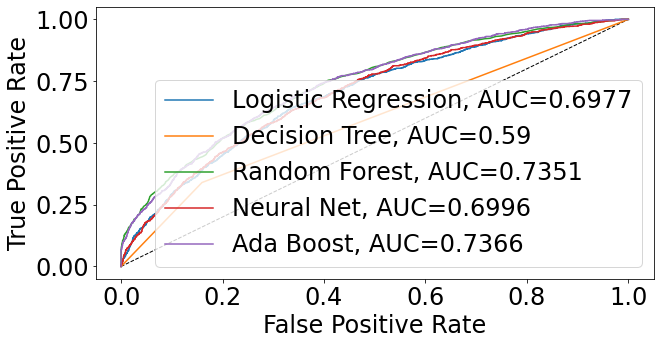

In [14]:
#Plot ROC Curve
plt.figure(0).clf()
fig = plt.subplots(figsize=(10,5))

plt.plot([0, 1], [0, 1], color = 'black', linewidth = 1, linestyle='dashed')
plt.plot(fpr_log,tpr_log,label="Logistic Regression, AUC="+str(auc_log))
plt.plot(fpr_tree,tpr_tree,label="Decision Tree, AUC="+str(auc_tree))
plt.plot(fpr_forest,tpr_forest,label="Random Forest, AUC="+str(auc_forest))
plt.plot(fpr_neural,tpr_neural,label="Neural Net, AUC="+str(auc_neural))
plt.plot(fpr_ada,tpr_ada,label="Ada Boost, AUC="+str(auc_ada))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()